nytt forsøk på en mer forståelig(kode, modell) for aksjeprediksjon, da ved bruk av LSTM-arkitekturen (long-short-term-memory)

DATA

In [4]:
import pandas as pd

#lage df av scatec data csv fra investing.com
df_scatec = pd.read_csv("C:\pythonlek\Fintech\Fintech_LSTM_Project-\data\Scatec Solar OL Stock Price History.csv")
df_scatec['Date'] = pd.to_datetime(df_scatec['Date'])
df_scatec = df_scatec.sort_values("Date").reset_index(drop=True)

#Linje under for å fjerne "k" fra alle volum verdier og gjøre om til float

df_scatec["Vol."] = df_scatec['Vol.'].astype(str).str.replace('K', '').astype(float) * 1000

df_scatec.head(n=1000)   

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-01-02,123.0,124.0,124.0,121.7,1370.0,-0.89%
1,2020-01-03,123.2,122.3,123.2,122.3,650.0,0.16%
2,2020-01-06,117.4,120.0,120.0,116.6,980.0,-4.71%
3,2020-01-07,116.5,118.7,118.7,116.1,1860.0,-0.77%
4,2020-01-08,118.8,116.7,119.0,115.0,850.0,1.97%
...,...,...,...,...,...,...,...
906,2025-09-12,102.0,102.0,102.0,102.0,30.0,-0.97%
907,2025-09-19,100.1,100.1,100.1,100.1,200.0,-1.86%
908,2025-09-22,100.0,100.0,100.0,100.0,100.0,-0.10%
909,2025-09-23,100.8,100.8,100.8,100.8,0.0,0.80%


In [5]:
#hente inn styringsrente for å se om det kan brukes som feature
df_styringsrente = pd.read_csv("C:\pythonlek\Fintech\Fintech_LSTM_Project-\data\IR (2).csv", sep=';')
df_styringsrente = df_styringsrente.loc[:, ['TIME_PERIOD', 'OBS_VALUE']]
df_styringsrente = df_styringsrente.rename(columns={"TIME_PERIOD": "Date", "OBS_VALUE": "Styringsrente"})
df_styringsrente['Date'] = pd.to_datetime(df_styringsrente['Date'])
df_styringsrente.head(n=15)


df_styringsrente["Styringsrente"] = df_styringsrente["Styringsrente"].astype(str).str.replace(',', '.').astype('float64')
df_styringsrente.info()
df_scatec.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1445 non-null   datetime64[ns]
 1   Styringsrente  1445 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      911 non-null    datetime64[ns]
 1   Price     911 non-null    float64       
 2   Open      911 non-null    float64       
 3   High      911 non-null    float64       
 4   Low       911 non-null    float64       
 5   Vol.      911 non-null    float64       
 6   Change %  911 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 49.9+ KB


kjøre en type "left join" for å merge dfs 

In [6]:
df = df_scatec.merge(df_styringsrente, on='Date', how='left')
df.info()

df.head(n=20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           911 non-null    datetime64[ns]
 1   Price          911 non-null    float64       
 2   Open           911 non-null    float64       
 3   High           911 non-null    float64       
 4   Low            911 non-null    float64       
 5   Vol.           911 non-null    float64       
 6   Change %       911 non-null    object        
 7   Styringsrente  911 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 57.1+ KB


,Date,Price,Open,High,Low,Vol.,Change %,Styringsrente
0,2020-01-02,123.0,124.0,124.0,121.7,1370.0,-0.89%,1.5
1,2020-01-03,123.2,122.3,123.2,122.3,650.0,0.16%,1.5
2,2020-01-06,117.4,120.0,120.0,116.6,980.0,-4.71%,1.5
3,2020-01-07,116.5,118.7,118.7,116.1,1860.0,-0.77%,1.5
4,2020-01-08,118.8,116.7,119.0,115.0,850.0,1.97%,1.5
5,2020-01-09,117.7,119.0,119.0,117.7,2160.0,-0.93%,1.5
6,2020-01-10,118.8,119.4,119.4,118.6,1870.0,0.93%,1.5
7,2020-01-13,118.4,121.2,121.2,118.2,870.0,-0.34%,1.5
8,2020-01-14,120.6,120.6,120.6,120.6,0.0,1.86%,1.5
9,2020-01-15,124.1,121.7,124.2,121.7,2690.0,2.90%,1.5


Scatec kurs, plot siste 5 år ish

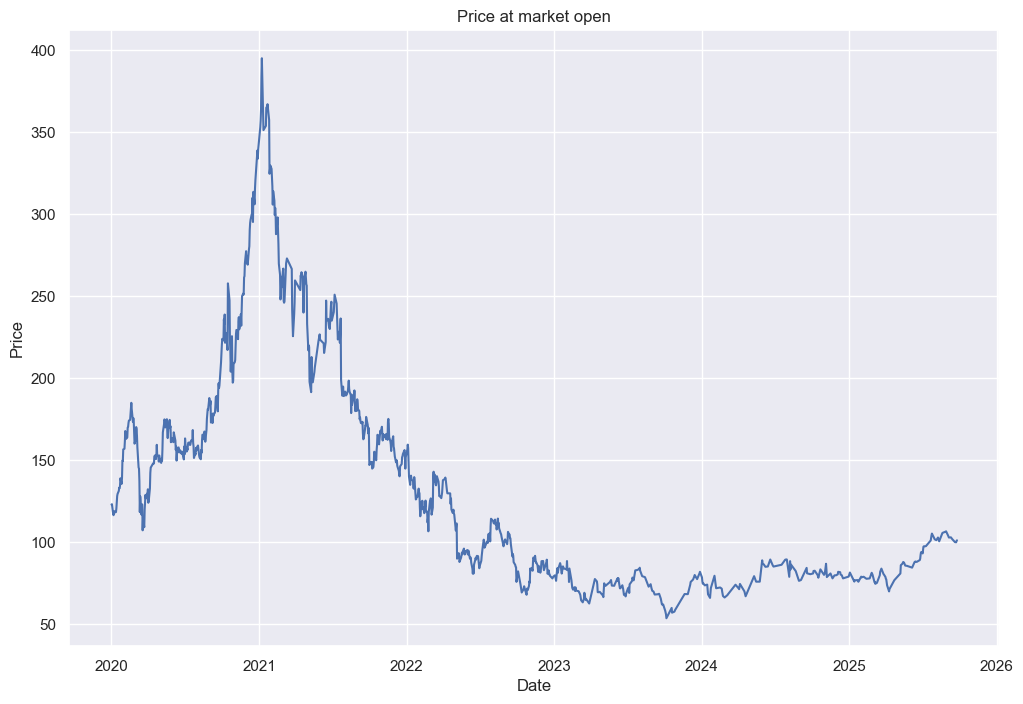

In [7]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df, x="Date", y = "Price")
plt.grid(True)
plt.title("Price at market open")
plt.show()

Over til modell, fokus tydelig kode 

først separere trenings og test data

In [8]:
def split_data(df):
    train_size = int(len(df) * 0.8)
    # klassisk 80/20 split.. 
    train_data = df.iloc[:train_size].reset_index(drop=True)
    test_data  = df.iloc[train_size:].reset_index(drop=True)
    return train_data, test_data

train_data, test_data = split_data(df)

Dataskalering

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_price = MinMaxScaler(feature_range=(0, 1))   #transform på typen x_i = (x - min) / (max - min)
scaler_volume = MinMaxScaler(feature_range=(0, 1))  #som gir maks i sample verdi 1 og min 0 // hovedsak for å unngå bias 
scaler_styringsrente = MinMaxScaler(feature_range=(0, 1))

#trenger at data skal være "float32"?? tydeligvis default i pytorch
train_price = train_data[['Price']].values.astype('float32').reshape(-1, 1) # worth noting, minmax krever 2d array, så [[]] fuker, (n,1)
train_volume = train_data[['Vol.']].values.astype('float32').reshape(-1, 1)
train_styringsrente = train_data[['Styringsrente']].values.astype('float32').reshape(-1, 1)  
#print(train_price), var for og sjekke form på pris ,, [[p_1], ... [p_n]]

test_price = test_data[['Price']].values.astype('float32')
test_volume = test_data[['Vol.']].values.astype('float32')
test_styringsrente = test_data[['Styringsrente']].values.astype('float32')

train_price_scaled = scaler_price.fit_transform(train_price)
train_volume_scaled = scaler_volume.fit_transform(train_volume)
train_styringsrente_scaled = scaler_styringsrente.fit_transform(train_styringsrente)
test_price_scaled = scaler_price.transform(test_price)
test_volume_scaled = scaler_volume.transform(test_volume)
test_styringsrente_scaled = scaler_styringsrente.transform(test_styringsrente)

# må passe input som en 3dim vector med scalert data 

#også spesifisere navn s.t. kan feede bare pris inn og ut. 
train_scaled_final_multivariable = np.hstack((train_price_scaled, train_volume_scaled, train_styringsrente_scaled))
test_scaled_final_multivariable = np.hstack((test_price_scaled, test_volume_scaled, test_styringsrente_scaled))   


Utvide til multi-horizon windows, vil predikere flere 1d, 1w, 1m 

In [16]:
def multi_horizon_windows(data, lookback=10, target_col=0, horizons=(1, 5, 20)):
    #må lage funksjon som lager input windows og target windows for flere horisonter

    X, y = [], []
    max_horizon = max(horizons)
    
    #loop for å lage datavinduene: på form (X: (n_samples, lookback, n_features), y: (n_samples, len(horizons)))
    for i in range(len(data) - lookback - max_horizon):
        # Input window: last 'lookback' timesteps with all 3 features
        X.append(data[i:i + lookback])
        
        # Target window: prices at different horizons
        targets = []
        for horizon in horizons:
            target_idx = i + lookback + horizon - 1  # -1 because indices start at 0
            targets.append(data[target_idx, target_col])
        
        y.append(targets)
    
    return np.array(X), np.array(y)

In [ ]:
# Create multi-horizon windows
lookback = 10
horizons = (1, 5, 20)  # t+1, t+5, t+20

X_train, y_train = multi_horizon_windows(train_scaled_final_multivariable, lookback=lookback, horizons=horizons)
X_test, y_test = multi_horizon_windows(test_scaled_final_multivariable, lookback=lookback, horizons=horizons)

print(f"X_train shape: {X_train.shape}")  # (n_samples, lookback, 3)
print(f"y_train shape: {y_train.shape}")  # (n_samples, 3) for [t+1, t+5, t+20]
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Example: first window and its targets
print(f"\nFirst training window input shape: {X_train[0].shape}")
print(f"First training window targets (scaled prices): {y_train[0]}")

X_train shape: (698, 10, 3)
y_train shape: (698, 3)
X_test shape: (153, 10, 3)
y_test shape: (153, 3)

First training window input shape: (10, 3)
First training window targets (scaled prices): [0.19715935 0.21160325 0.32384446]
